In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
from utils.config import Config
from learner.dataset import FragmentDataset, DataCollator
from utils.parser import command_parser
from learner.model import Loss, Frag2Mol
import argparse
import pickle
from torch.utils.data import Dataset, DataLoader

from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from learner.trainer import Trainer, save_ckpt
from torch.nn import functional as F
import matplotlib.pyplot as plt
import torch.nn as nn


/home/teddy_t/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plot Latent Space from training

In [3]:
config = pickle.load(open('RUNS/2022-07-15@11:41:09-LAPTOP-E1483HNR-CHEMBL/config/config.pkl', "rb"))
vocab = pickle.load(open('RUNS/2022-07-15@11:41:09-LAPTOP-E1483HNR-CHEMBL/config/vocab.pkl', "rb"))

In [4]:
dataset = FragmentDataset(config)
vocab = dataset.get_vocab()
load_last = config.get('load_last')
trainer, epoch = Trainer.load(config, vocab, last=load_last)

Vocab created/loaded. Size: 90175. Effective size: 90175. Time elapsed: 00:00:00.
loading best_loss.pt at epoch 9...


In [4]:
data_sample, mu_stack = trainer.train(dataset.get_loader(), epoch + 1)

Vocab created/loaded. Size: 90175. Effective size: 90175. Time elapsed: 00:00:00.
loading best_loss.pt at epoch 9...
Data loaded. Size: 1090461. Time elapsed: 00:00:00.


/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


64
Epoch loss:  0.17289263010025024
len:  34077
Dataset: <class 'tuple'>
96
Epoch loss:  0.4078162908554077
len:  34077
Dataset: <class 'tuple'>
128
Epoch loss:  0.5805893093347549
len:  34077
Dataset: <class 'tuple'>
160
Epoch loss:  0.8800695985555649
len:  34077
Dataset: <class 'tuple'>
192
Epoch loss:  1.1888530403375626
len:  34077
Dataset: <class 'tuple'>
224
Epoch loss:  1.5157525092363358
len:  34077
Dataset: <class 'tuple'>
256
Epoch loss:  1.7229757755994797
len:  34077
Dataset: <class 'tuple'>
288
Epoch loss:  1.960098534822464
len:  34077
Dataset: <class 'tuple'>
320
Epoch loss:  2.160068765282631
len:  34077
Dataset: <class 'tuple'>
352
Epoch loss:  2.4088552743196487
len:  34077
Dataset: <class 'tuple'>
384
Epoch loss:  2.6935195177793503
len:  34077
Dataset: <class 'tuple'>
416
Epoch loss:  2.835120916366577
len:  34077
Dataset: <class 'tuple'>
448
Epoch loss:  3.150307983160019
len:  34077
Dataset: <class 'tuple'>
480
Epoch loss:  3.316389635205269
len:  34077
Dataset: 

Epoch loss:  27.242286764085293
len:  34077
Dataset: <class 'tuple'>
3680
Epoch loss:  27.445202223956585
len:  34077
Dataset: <class 'tuple'>
3712
Epoch loss:  27.634848915040493
len:  34077
Dataset: <class 'tuple'>
3744
Epoch loss:  27.973315499722958
len:  34077
Dataset: <class 'tuple'>
3776
Epoch loss:  28.1959111019969
len:  34077
Dataset: <class 'tuple'>
3808
Epoch loss:  28.423507653176785
len:  34077
Dataset: <class 'tuple'>
3840
Epoch loss:  28.612421549856663
len:  34077
Dataset: <class 'tuple'>
3872
Epoch loss:  28.821154482662678
len:  34077
Dataset: <class 'tuple'>
3904
Epoch loss:  28.984826751053333
len:  34077
Dataset: <class 'tuple'>
3936
Epoch loss:  29.151772387325764
len:  34077
Dataset: <class 'tuple'>
3968
Epoch loss:  29.343397699296474
len:  34077
Dataset: <class 'tuple'>
4000
Epoch loss:  29.46850637346506
len:  34077
Dataset: <class 'tuple'>
4032
Epoch loss:  29.56354756653309
len:  34077
Dataset: <class 'tuple'>
4064
Epoch loss:  29.809740766882896
len:  3407

Epoch loss:  52.68371531367302
len:  34077
Dataset: <class 'tuple'>
7264
Epoch loss:  52.899058654904366
len:  34077
Dataset: <class 'tuple'>
7296
Epoch loss:  53.12840047478676
len:  34077
Dataset: <class 'tuple'>
7328
Epoch loss:  53.31436009705067
len:  34077
Dataset: <class 'tuple'>
7360
Epoch loss:  53.513392210006714
len:  34077
Dataset: <class 'tuple'>
7392
Epoch loss:  53.79151776432991
len:  34077
Dataset: <class 'tuple'>
7424
Epoch loss:  53.979029819369316
len:  34077
Dataset: <class 'tuple'>
7456
Epoch loss:  54.23101417720318
len:  34077
Dataset: <class 'tuple'>
7488
Epoch loss:  54.40046267211437
len:  34077
Dataset: <class 'tuple'>
7520
Epoch loss:  54.61808027327061
len:  34077
Dataset: <class 'tuple'>
7552
Epoch loss:  54.90964566171169
len:  34077
Dataset: <class 'tuple'>
7584
Epoch loss:  55.24100239574909
len:  34077
Dataset: <class 'tuple'>
7616
Epoch loss:  55.4862712174654
len:  34077
Dataset: <class 'tuple'>
7648
Epoch loss:  55.6717010140419
len:  34077
Dataset

In [7]:
data_sample_index = [item for sublist in data_sample for item in sublist]

In [16]:
dataset.data.iloc[data_sample_index].logP.to_numpy()

array([3.92612, 4.1662 , 1.0295 , ..., 3.11182, 3.7222 , 4.64287])

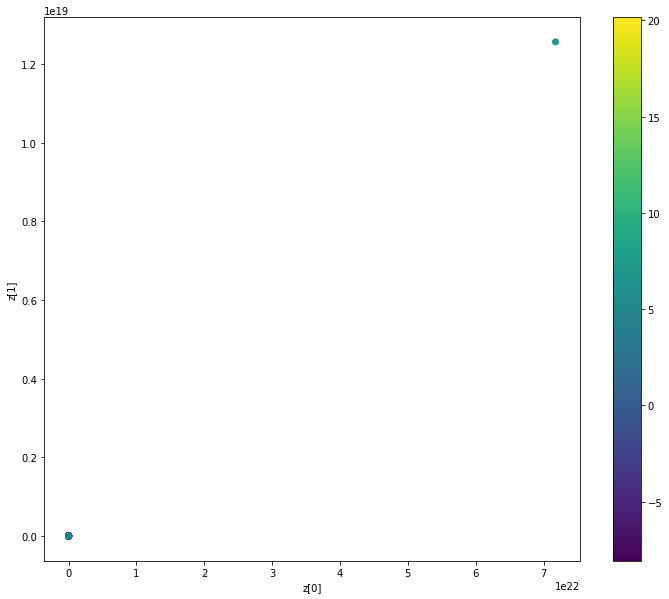

In [43]:
plt.figure(figsize=(12, 10))
plt.scatter(mu_stack[:9984, 0].detach().numpy(), mu_stack[:9984, 1].detach().numpy(), c=dataset.data.iloc[data_sample_index].logP.to_numpy())
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
#plt.xlim(-0.0008, 0.0008)
#plt.ylim(-0.0009, 0.0009)
plt.show()

In [40]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
x = mu_stack[:9984].detach().numpy()
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3'])

In [41]:
principalDf

,pc1,pc2,pc3
0,-0.077090,-0.050692,0.017952
1,-0.077132,-0.052495,0.017956
2,-0.077131,-0.052482,0.017941
3,-0.077131,-0.052482,0.017957
4,-0.077131,-0.052482,0.017955
...,...,...,...
9979,-0.077164,-0.052512,-0.798874
9980,-0.077159,-0.052507,-0.748614
9981,-0.077160,-0.052508,-0.803975
9982,-0.077160,-0.052508,-0.865643


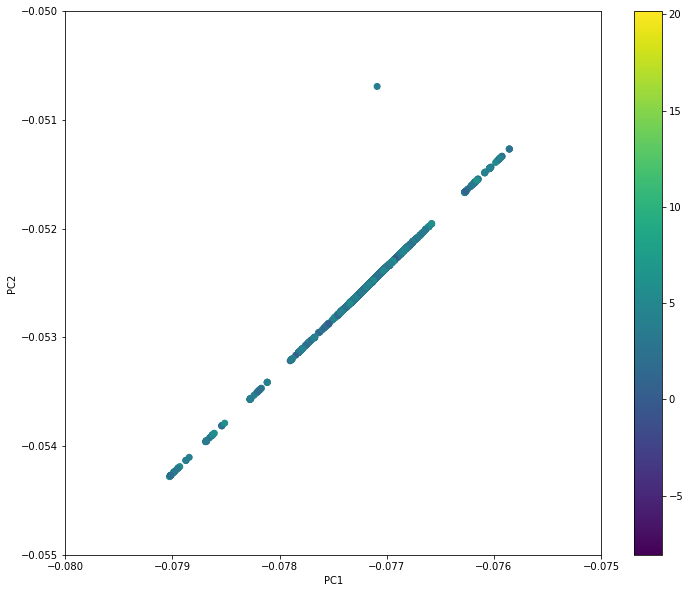

In [42]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            c=dataset.data.iloc[data_sample_index].logP.to_numpy())
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.xlim(-0.08, -0.075)
plt.ylim(-0.055, -0.05)
plt.show()

In [5]:
def get_optimizer(config, model):
    return Adam(model.parameters(), lr=config.get('optim_lr'))


def get_scheduler(config, optimizer):
    return StepLR(optimizer,
                  step_size=config.get('sched_step_size'),
                  gamma=config.get('sched_gamma'))

In [6]:
model = Frag2Mol(config, vocab)
optimizer = get_optimizer(config, model)
scheduler = get_scheduler(config, optimizer)
criterion = Loss(config, pad=vocab.PAD)
model = model.cuda()
losses = []
best_loss = np.float('inf')
scores = []
best_score = - np.float('inf')

<ipython-input-6-1785cb37f18f>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_loss = np.float('inf')
<ipython-input-6-1785cb37f18f>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_score = - np.float('inf')


In [7]:
model

Frag2Mol(
  (embedder): Embedding(90175, 64)
  (latent2rnn): Linear(in_features=100, out_features=64, bias=True)
  (encoder): Encoder(
    (rnn): GRU(64, 64, num_layers=2, batch_first=True, dropout=0.3)
    (rnn2mean): Linear(in_features=128, out_features=100, bias=True)
    (rnn2logv): Linear(in_features=128, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (rnn): GRU(64, 64, num_layers=2, batch_first=True, dropout=0.3)
    (rnn2out): Linear(in_features=64, out_features=90175, bias=True)
  )
)

In [8]:
batch = next(iter(dataset.get_loader()))

Data loaded. Size: 1090461. Time elapsed: 00:00:00.


/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
device = torch.device('cpu')
src = batch[0].to(device)
tgt = batch[1]
lengths = batch[2]
index = batch[3]

In [10]:
device

device(type='cpu')

In [17]:
model = model.to(device)

In [100]:
yhat = model(Variable(src), lengths)

In [30]:
logP = dataset.data.iloc[list(index)].logP.to_numpy()

In [15]:
output, mu, sigma = model.forward(Variable(src), lengths)

In [19]:
mu.size()

torch.Size([32, 100])

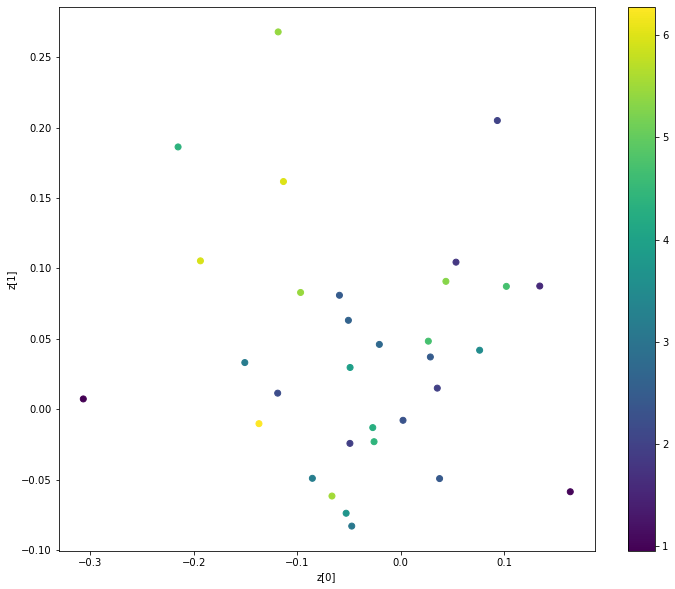

In [31]:
plt.figure(figsize=(12, 10))
plt.scatter(mu[:, 0].detach().numpy(), mu[:, 1].detach().numpy(), c = logP)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
plt.show()

# Plot Latent Space

In [3]:
config = pickle.load(open('RUNS/2022-08-06@23:39:14-LAPTOP-E1483HNR-CHEMBL/config/config.pkl', "rb"))
vocab = pickle.load(open('RUNS/2022-08-06@23:39:14-LAPTOP-E1483HNR-CHEMBL/config/vocab.pkl', "rb"))
dataset = FragmentDataset(config)
vocab = dataset.get_vocab()
model = Frag2Mol(config, vocab)
device = torch.device('cuda')
model = model.to(device)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xff in position 144835: invalid start byte

In [4]:
load_last = config.get('load_last')
trainer, epoch = Trainer.load(config, vocab, last=load_last)
model = trainer.model

loading best_loss.pt at epoch 20...


In [5]:
model.mlp

MLP(
  (layers): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [6]:
loader = dataset.get_loader()
mu_stack = torch.empty((32,100)).cuda()
latent_output = torch.empty((32,100)).cuda()
data_sample = []
rnn2mean_weight = model.encoder.rnn2mean.weight

Data loaded. Size: 1090461. Time elapsed: 00:00:00.


/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
rnn2mean_weight

Parameter containing:
tensor([[ 0.0632, -0.0645,  0.0260,  ..., -0.0478,  0.0333, -0.0541],
        [ 0.0496, -0.0355,  0.0672,  ..., -0.0357, -0.0403,  0.0804],
        [ 0.0212, -0.0733, -0.0352,  ..., -0.0299, -0.0006,  0.0705],
        ...,
        [-0.0410,  0.0131, -0.0406,  ...,  0.0909,  0.0563, -0.0400],
        [ 0.0700, -0.0651,  0.0741,  ..., -0.0654, -0.0317, -0.0646],
        [-0.0485, -0.0700,  0.0692,  ...,  0.0602, -0.0167,  0.0078]],
       device='cuda:0', requires_grad=True)

In [8]:
for idx, (src, tgt, lengths, data) in enumerate(loader):
    ###
    src, tgt = Variable(src), Variable(tgt)
    if config.get('use_gpu'):
        src = src.cuda()
        tgt = tgt.cuda()

    output, mu, sigma, z, pred = model.forward(src, lengths)
    
    print(torch.all(rnn2mean_weight == model.encoder.rnn2mean.weight))
    model.encoder.rnn2mean.weight.size() == model.encoder.rnn2mean.weight.size()
    
    ###Teddy Code
    data_sample.append(list(data))
    mu_stack = torch.cat((mu_stack, mu), 0)
    z_sum = z[0] + z[1]
    latent_output = torch.cat((latent_output, z_sum),0)
    print(len(mu_stack))
    if len(mu_stack) > 10000:
        break

tensor(True, device='cuda:0')
64
tensor(True, device='cuda:0')
96
tensor(True, device='cuda:0')
128
tensor(True, device='cuda:0')
160
tensor(True, device='cuda:0')
192
tensor(True, device='cuda:0')
224
tensor(True, device='cuda:0')
256
tensor(True, device='cuda:0')
288
tensor(True, device='cuda:0')
320
tensor(True, device='cuda:0')
352
tensor(True, device='cuda:0')
384
tensor(True, device='cuda:0')
416
tensor(True, device='cuda:0')
448
tensor(True, device='cuda:0')
480
tensor(True, device='cuda:0')
512
tensor(True, device='cuda:0')
544
tensor(True, device='cuda:0')
576
tensor(True, device='cuda:0')
608
tensor(True, device='cuda:0')
640
tensor(True, device='cuda:0')
672
tensor(True, device='cuda:0')
704
tensor(True, device='cuda:0')
736
tensor(True, device='cuda:0')
768
tensor(True, device='cuda:0')
800
tensor(True, device='cuda:0')
832
tensor(True, device='cuda:0')
864
tensor(True, device='cuda:0')
896
tensor(True, device='cuda:0')
928
tensor(True, device='cuda:0')
960
tensor(True, dev

tensor(True, device='cuda:0')
7904
tensor(True, device='cuda:0')
7936
tensor(True, device='cuda:0')
7968
tensor(True, device='cuda:0')
8000
tensor(True, device='cuda:0')
8032
tensor(True, device='cuda:0')
8064
tensor(True, device='cuda:0')
8096
tensor(True, device='cuda:0')
8128
tensor(True, device='cuda:0')
8160
tensor(True, device='cuda:0')
8192
tensor(True, device='cuda:0')
8224
tensor(True, device='cuda:0')
8256
tensor(True, device='cuda:0')
8288
tensor(True, device='cuda:0')
8320
tensor(True, device='cuda:0')
8352
tensor(True, device='cuda:0')
8384
tensor(True, device='cuda:0')
8416
tensor(True, device='cuda:0')
8448
tensor(True, device='cuda:0')
8480
tensor(True, device='cuda:0')
8512
tensor(True, device='cuda:0')
8544
tensor(True, device='cuda:0')
8576
tensor(True, device='cuda:0')
8608
tensor(True, device='cuda:0')
8640
tensor(True, device='cuda:0')
8672
tensor(True, device='cuda:0')
8704
tensor(True, device='cuda:0')
8736
tensor(True, device='cuda:0')
8768
tensor(True, device=

In [9]:
data_sample_index = [item for sublist in data_sample for item in sublist]

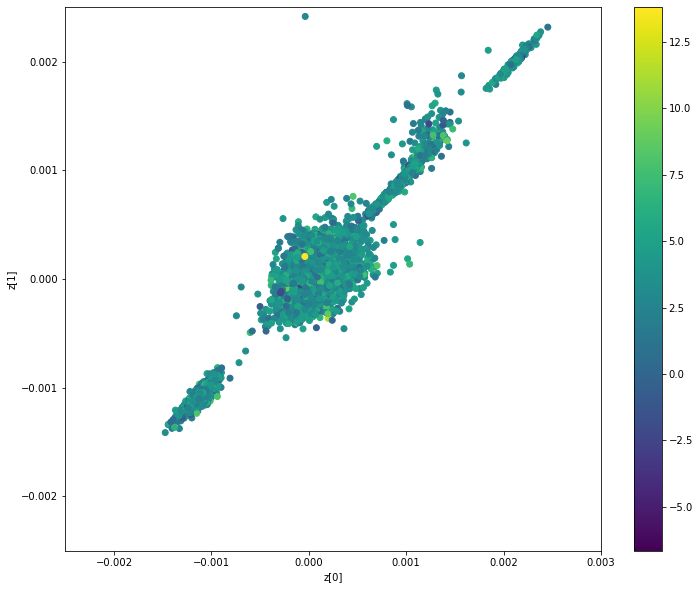

In [15]:
plt.figure(figsize=(12, 10))
plt.scatter(mu_stack[:9984, 0].cpu().detach().numpy(), mu_stack[:9984, 1].cpu().detach().numpy(), c=dataset.data.iloc[data_sample_index].logP.to_numpy())
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
plt.xlim(-0.0025, 0.003)
plt.ylim(-0.0025, 0.0025)
plt.show()

In [49]:
mu_stack.cpu().detach()

tensor([[-5.4082e-23,  4.5783e-41, -6.5991e+18,  ...,  4.5783e-41,
          1.4013e-45,  4.5783e-41],
        [ 4.2039e-45,  2.2421e-44,  4.2039e-45,  ...,  7.3787e+28,
         -6.6277e+18,  3.0718e-41],
        [ 1.4938e-42,  5.8269e-10,  0.0000e+00,  ...,  4.0798e-11,
         -6.6282e+18,  3.0718e-41],
        ...,
        [-2.7716e-06, -2.5708e-05, -5.7444e-05,  ...,  2.3637e-05,
          4.4413e-05, -3.8497e-05],
        [-3.1218e-06, -2.3138e-05, -5.6438e-05,  ...,  2.1938e-05,
          4.6022e-05, -4.1224e-05],
        [-1.8924e-06, -2.6543e-05, -5.7220e-05,  ...,  2.0269e-05,
          4.5188e-05, -4.2669e-05]])

# Predict property with MLP

In [11]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [12]:
data = dataset.data.iloc[data_sample_index]

In [13]:
labels = torch.tensor(data.logP.values)

In [14]:
MLP_model = MLP()

In [15]:
optimizer = torch.optim.Adam(MLP_model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
latent_output_data = F.normalize(latent_output_data)

In [24]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
epochs = 15

latent_output_data = latent_output
for epoch in range(epochs):
    MLP_model.train()
    
    train_losses = []
    valid_losses = [] 
    output_final = []
    for i, (latent_data) in enumerate(latent_output_data[:9984]):
        
        outputs = MLP_model(Variable(latent_data.cpu()))
        if epoch + 1 == epochs:
            output_final.append(outputs.item())
        loss = loss_fn(outputs.type(torch.float64), labels[i])
        print(output)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
            
    model.eval()
    mean_train_losses.append(np.mean(train_losses))
    print('epoch : {}, train loss : {:.4f}'\
         .format(epoch+1, np.mean(train_losses)))

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

tensor([[[-8.9169e-02,  4.6909e-01, -3.0616e+01,  ..., -7.0752e-01,
          -8.5608e-03,  1.0444e+00],
         [-6.0901e-01,  2.7593e-01, -1.2594e+01,  ..., -8.0360e-02,
           4.3702e-01,  5.8997e-01],
         [-4.5302e-01, -5.2368e-01,  8.4140e+00,  ..., -5.8929e-01,
          -1.9220e-01,  9.9374e-01],
         [ 5.7764e-01, -1.7240e-01,  2.7661e+01,  ..., -8.9117e-02,
          -2.6126e-01, -3.5087e-01]],

        [[-1.1073e-01,  4.1286e-01, -3.1910e+01,  ..., -7.2174e-01,
          -3.2709e-02,  1.0611e+00],
         [-4.2541e-01, -2.2723e-02, -1.1984e+01,  ...,  8.3474e-03,
           3.4151e-01,  5.2365e-01],
         [-4.1929e-01, -5.3369e-01,  9.8312e+00,  ..., -3.5996e-01,
          -4.9887e-02,  1.0851e+00],
         [ 4.5766e-01, -2.5973e-02,  2.8303e+01,  ...,  2.7657e-02,
          -2.2860e-01, -3.7483e-01]],

        [[-9.5022e-02,  4.3881e-01, -3.1175e+01,  ..., -7.0305e-01,
           1.3689e-03,  1.0355e+00],
         [-4.4893e-01, -6.9366e-02, -1.7593e+01,  .

KeyboardInterrupt: 

In [17]:
latent_output

tensor([[-7.0019e-37,  4.5650e-41, -7.0019e-37,  ...,  5.0447e-44,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  2.3822e-44,  ..., -7.5131e-01,
         -9.2188e-01,  6.9752e-01],
        [ 6.8689e-01,  6.7336e-01,  6.0898e-01,  ..., -5.6957e-01,
         -7.0896e-01,  5.8296e-01],
        ...,
        [-2.2524e-03, -2.1817e-03, -1.9388e-03,  ...,  2.1066e-03,
          2.0289e-03, -1.9469e-03],
        [-2.4287e-03, -2.2918e-03, -2.0716e-03,  ...,  2.1121e-03,
          1.9659e-03, -1.8949e-03],
        [-2.3081e-03, -2.3138e-03, -1.9277e-03,  ...,  2.2009e-03,
          2.0236e-03, -1.9731e-03]], device='cuda:0', grad_fn=<CatBackward0>)

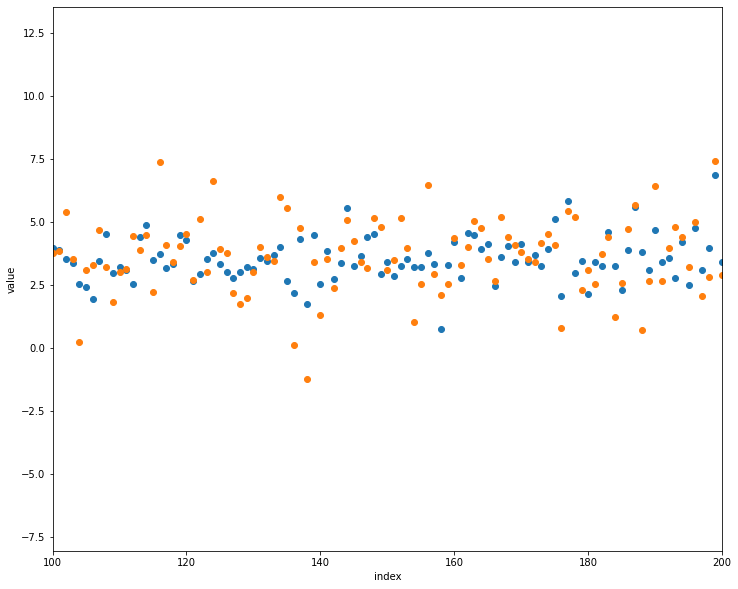

In [92]:
plt.figure(figsize=(12, 10))
plt.scatter( np.arange(len(output_final)),np.array(output_final))
plt.scatter( np.arange(len(labels.detach().numpy())),np.array(labels.detach().numpy()))
plt.xlabel("index")
plt.ylabel("value")
plt.xlim(100,200)
plt.show()

# Plot Net

In [62]:
outputs, mu, sigma, z, pred = model(src, lengths)

In [63]:
from torchviz import make_dot

make_dot(outputs, params=dict(list(model.named_parameters()))).render("frag_20_torchviz", format="png")

'frag_20_torchviz.png'

# Property Predictor